In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(sys.path[0] + '/../'))
torch.cuda.set_device(1)
print("Set CUDA:%d as current device." % torch.cuda.current_device())

from data.spherical_view_syn import *
from configs.spherical_view_syn import SphericalViewSynConfig
from utils import netio
from utils import img
from utils import device
from utils import view
from components import refine


os.chdir(sys.path[0] + '/../data/us_gas_all_in_one')
print('Change working directory to ', os.getcwd())
torch.autograd.set_grad_enabled(False)

Set CUDA:1 as current device.
Change working directory to  /home/dengnc/deep_view_syn/data/us_gas_all_in_one


In [8]:
# Load Config
model_path = 'fovea@nmsl-rgb_e10_fc128x4_d1-50_s32.pth'
config = SphericalViewSynConfig()
config.from_id(os.path.splitext(os.path.basename(model_path))[0])
config.SAMPLE_PARAMS['perturb_sample'] = False
config.print()

# Load Dataset
view_dataset = SphericalViewSynDataset(
    'views.json', load_images=False, load_depths=False,
    color=config.COLOR, calculate_rays=False)
ref_dataset = SphericalViewSynDataset(
    'ref.json', load_images=False, load_depths=False,
    color=config.COLOR, calculate_rays=False)
print('Dataset loaded.')

def read_ref_images(idx):
    patt = 'ref/view_%04d.png'
    if isinstance(idx, torch.Tensor) and len(idx.size()) > 0:
        return img.load([patt % i for i in idx]).to(device.default())
    else:
        return img.load(patt % idx).to(device.default())

indices = torch.arange(view_dataset.n_views, device=device.default()).view(
    view_dataset.samples)
ref_indices = torch.arange(ref_dataset.n_views, device=device.default()).view(
    ref_dataset.samples)
cam_params = view.CameraParam({
    "fov": 20,
    "cx": 0.5,
    "cy": 0.5,
    "normalized": True
}, (100, 100)).to(device.default())
ref_cam_params = ref_dataset.cam_params

# Load Spher net
net = config.create_net().to(device.default())
netio.load(model_path, net)
print('Net loaded.')

vr_cam = view.CameraParam({
    'fov': 110,
    'cx': 0.5,
    'cy': 0.5,
    'normalized': True
}, (1600, 1440))

def adjust_cam(cam, vr_cam, gaze_center):
    fovea_offset = (
        (gaze_center[0]) / vr_cam.f[0].item() * cam.f[0].item(),
        (gaze_center[1]) / vr_cam.f[1].item() * cam.f[1].item()
    )
    cam.c[0] = cam.res[1] / 2 - fovea_offset[0]
    cam.c[1] = cam.res[0] / 2 - fovea_offset[1]

==== Config fovea ====
Net type:  nmsl
Encode dim:  10
Optimizer decay:  0
Normalize:  False
Direction as input:  False
Full-connected network parameters: {'nf': 128, 'n_layers': 4, 'skips': []}
Sample parameters {'spherical': True, 'depth_range': (1.0, 50.0), 'n_samples': 32, 'perturb_sample': False, 'lindisp': True, 'inverse_r': True}
Dataset loaded.
Load net from fovea@nmsl-rgb_e10_fc128x4_d1-50_s32.pth ...
Net loaded.


test_view_coord (2, 2, 2, 2, 2)
test_view_coord_in_ref (3, 3, 3, 4, 1)
ref_dataset.samples [7, 7, 7, 9, 3]
ref_indices.size() torch.Size([7, 7, 7, 9, 3])
indices.size() torch.Size([5, 5, 5, 5, 5])
tensor([2360, 7658, 1602, 6900], device='cuda:1')
guides_idx: tensor([2360, 7658, 1602, 6900], device='cuda:1')
t torch.Size([4, 1, 1, 3]) p torch.Size([4, 10000, 3]) out torch.Size([4, 100, 100, 3])
torch.Size([4, 100, 100, 2]) torch.Size([4, 3, 100, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


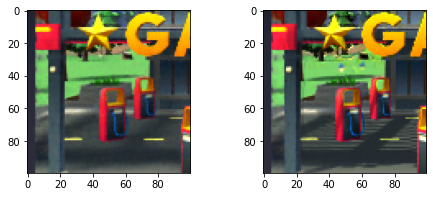

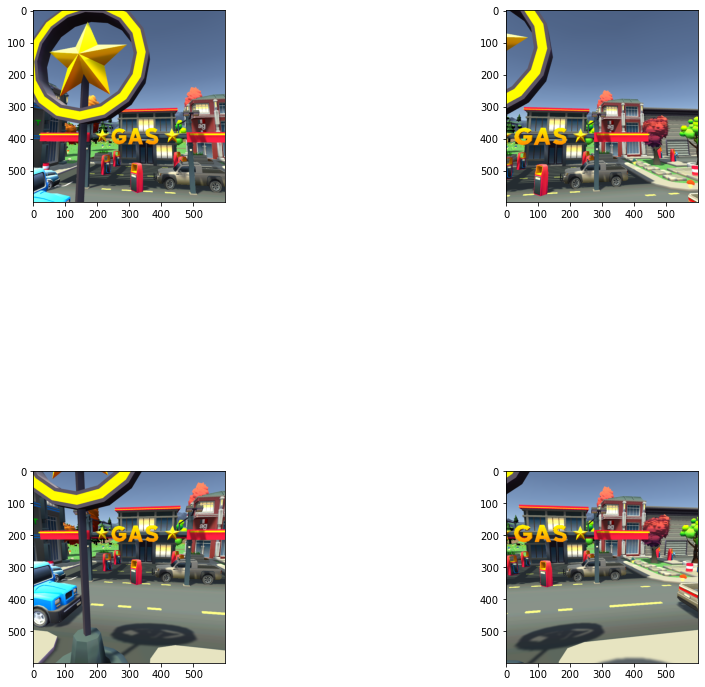

In [12]:
center = (-187, 64)
test_view_coord = list(val // 2 for val in view_dataset.samples)
#test_view_coord[3] -= 1
test_view_coord = tuple(test_view_coord)
test_view_coord_in_ref = (
    test_view_coord[0] + 1, test_view_coord[1] + 1, test_view_coord[2] + 1,
    test_view_coord[3] + 2, test_view_coord[4] - 1,
)
print('test_view_coord', test_view_coord)
print('test_view_coord_in_ref', test_view_coord_in_ref)
print('ref_dataset.samples', ref_dataset.samples)
print('ref_indices.size()', ref_indices.size())
print('indices.size()', indices.size())
test_view_idx = indices[test_view_coord]
a = ref_indices[test_view_coord_in_ref[0] - 2, test_view_coord_in_ref[1] + 2, test_view_coord_in_ref[2],
                test_view_coord_in_ref[3] - 1, test_view_coord_in_ref[4] + 1][None]
b = ref_indices[test_view_coord_in_ref[0] + 2, test_view_coord_in_ref[1] + 2, test_view_coord_in_ref[2],
                test_view_coord_in_ref[3] + 1, test_view_coord_in_ref[4] + 1][None]
c = ref_indices[test_view_coord_in_ref[0] - 2, test_view_coord_in_ref[1] - 2, test_view_coord_in_ref[2],
                test_view_coord_in_ref[3] - 1, test_view_coord_in_ref[4] - 1][None]
d = ref_indices[test_view_coord_in_ref[0] + 2, test_view_coord_in_ref[1] - 2, test_view_coord_in_ref[2],
                test_view_coord_in_ref[3] + 1, test_view_coord_in_ref[4] - 1][None]
bound_view_idxs = torch.cat([a, b, c, d])
print(bound_view_idxs)
# bound_view_idxs = [
#    indices[center_view_coord[0], center_view_coord[1], center_view_coord[2],
#            center_view_coord[3] - 1, center_view_coord[4]],
#    indices[center_view_coord[0], center_view_coord[1], center_view_coord[2],
#            center_view_coord[3] + 1, center_view_coord[4]],
# ]

def get_guides(view_coord):
    coord_offset = [val // 2 - view_dataset.samples[i] // 2 for i, val in enumerate(ref_dataset.samples)]
    guides_coord = [
        [
            view_coord[0] - 2, view_coord[1] + 2, view_coord[2],
            view_coord[3] - 1, view_coord[4] + 1
        ],
        [
            view_coord[0] + 2, view_coord[1] + 2, view_coord[2],
            view_coord[3] + 1, view_coord[4] + 1
        ],
        [
            view_coord[0] - 2, view_coord[1] - 2, view_coord[2],
            view_coord[3] - 1, view_coord[4] - 1
        ],
        [
            view_coord[0] + 2, view_coord[1] - 2, view_coord[2],
            view_coord[3] + 1, view_coord[4] - 1
        ]
    ]
    for coord in guides_coord:
        for i in range(len(coord_offset)):
            coord[i] += coord_offset[i]
    ref_indices = torch.arange(0, ref_dataset.n_views,
                               device=device.default()).view(ref_dataset.samples)
    guides_idx = torch.stack([
        ref_indices[tuple(coord)] for coord in guides_coord
    ])
    print('guides_idx:', guides_idx)
    guides_image = read_ref_images(guides_idx).to(device.default())
    guides_trans = view.Trans(ref_dataset.view_centers[guides_idx],
                              ref_dataset.view_rots[guides_idx])
    return refine.GuideRefinement(guides_image, guides_trans, ref_cam_params, net)

guide_refine = get_guides(test_view_coord)

def gen(fovea_center, trans):
    adjust_cam(cam_params, vr_cam, fovea_center)

    fovea_rays_o, fovea_rays_d = cam_params.get_global_rays(trans)  # (H_fovea, W_fovea, 3)

    fovea_inferred, fovea_depthmap = net(
        fovea_rays_o.view(-1, 3), fovea_rays_d.view(-1, 3), ret_depth=True)
    fovea_inferred = fovea_inferred.view(
        cam_params.res[0], cam_params.res[1], -1).permute(2, 0, 1)  # (C, H_fovea, W_fovea)
    fovea_depthmap = fovea_depthmap.view(cam_params.res[0], cam_params.res[1])
    
    fovea_refined = guide_refine.refine_by_guide(fovea_inferred, fovea_depthmap,
                                     fovea_rays_o, fovea_rays_d, False)

    return {
        'fovea_raw': fovea_inferred,
        'fovea': fovea_refined,
        'fovea_depth': fovea_depthmap
    }

#adjust_cam(cam_params, vr_cam, center)
trans = view.Trans(view_dataset.view_centers[test_view_idx],
                   view_dataset.view_rots[test_view_idx])
#rays_o, rays_d = cam_params.get_global_rays(trans, flatten=True)

#inferred, depthmap = net(rays_o.view(-1, 3),
#                         rays_d.view(-1, 3), ret_depth=True)
#inferred = inferred.view(
#    cam_params.res[0], cam_params.res[1], -1).permute(2, 0, 1)
#inferred = nn_f.upsample_bilinear(inferred.unsqueeze(0), scale_factor=2)[0]
#depthmap = depthmap.view(cam_params.res[0], cam_params.res[1])
#depthmap = nn_f.upsample_bilinear(depthmap[None, None, :, :], scale_factor=2)[0, 0]
#gt = view_dataset.view_images[test_view_idx]
#bounds_img = read_ref_images(bound_view_idxs)
#bounds_o = ref_dataset.view_centers[bound_view_idxs]
#bounds_r = ref_dataset.view_rots[bound_view_idxs]
images = gen(center, trans)
inferred = images['fovea_raw']
refined = images['fovea']


#guide_refine = refine.GuideRefinement(bounds_img, view.Trans(bounds_o, bounds_r), ref_cam_params, net)
#refined = guide_refine.refine_by_guide(inferred, depthmap, rays_o, rays_d, False)

# warped = [nn_f.grid_sample(bounds_img[i], bounds_warp[i])
#          for i in range(len(bounds_warp))]
# warped_inferred = [nn_f.grid_sample(
#    bounds_inferred[i], bounds_warp[i]) for i in range(len(bounds_warp))]

fig = plt.figure(figsize=(12, 3))
plt.set_cmap('Greys_r')
plt.subplot(1, 3, 1)
img.plot(inferred)
plt.subplot(1, 3, 2)
img.plot(refined)
#plt.subplot(1, 3, 3)
#img.plot(gt)
plt.show()


def plot_image_matrices(center_image, ref_images):
    if len(ref_images) == 2:
        plt.figure(figsize=(12, 4))
        plt.set_cmap('Greys_r')
        plt.subplot(1, 3, 1)
        img.plot(ref_images[0])
        plt.subplot(1, 3, 3)
        img.plot(ref_images[1])
        if center_image != None:
            plt.subplot(1, 3, 2)
            img.plot(center_image)
    elif len(ref_images) == 4:
        plt.figure(figsize=(12, 12))
        plt.set_cmap('Greys_r')
        plt.subplot(3, 3, 1)
        img.plot(ref_images[0])
        plt.subplot(3, 3, 3)
        img.plot(ref_images[1])
        plt.subplot(3, 3, 7)
        img.plot(ref_images[2])
        plt.subplot(3, 3, 9)
        img.plot(ref_images[3])
        if center_image != None:
            plt.subplot(3, 3, 5)
            img.plot(center_image)
    plt.show()


#plot_image_matrices(input, warped_inferred)
plot_image_matrices(None, bounds_img)
# plot_image_matrices(torch.cat(warped[0:3], 1) if len(
#    warped) >= 3 else torch.cat(warped + [torch.zeros_like(warped[0])], 1), warped)
